In [1]:
import pandas as pd
import matplotlib.pyplot as plt

restaurants = pd.read_csv("restaurants.csv")
reviews = pd.read_csv("reviews.csv")

restaurants_small = restaurants[["business_id", "name", "city", "state", "categories"]]
reviews_small = reviews[["business_id", "stars", "date"]]

df = reviews_small.merge(restaurants_small, on="business_id", how="left")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

df.head()

,business_id,stars,date,name,city,state,categories,year
0,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30,Kettle Restaurant,Tucson,AZ,"Restaurants, Breakfast & Brunch",2014
1,YjUWPpI6HXG530lwP-fb2A,2.0,2015-09-10 02:41:13,Kettle Restaurant,Tucson,AZ,"Restaurants, Breakfast & Brunch",2015
2,YjUWPpI6HXG530lwP-fb2A,5.0,2017-08-18 01:42:46,Kettle Restaurant,Tucson,AZ,"Restaurants, Breakfast & Brunch",2017
3,YjUWPpI6HXG530lwP-fb2A,5.0,2015-09-26 16:13:09,Kettle Restaurant,Tucson,AZ,"Restaurants, Breakfast & Brunch",2015
4,YjUWPpI6HXG530lwP-fb2A,3.0,2015-06-22 16:08:27,Kettle Restaurant,Tucson,AZ,"Restaurants, Breakfast & Brunch",2015


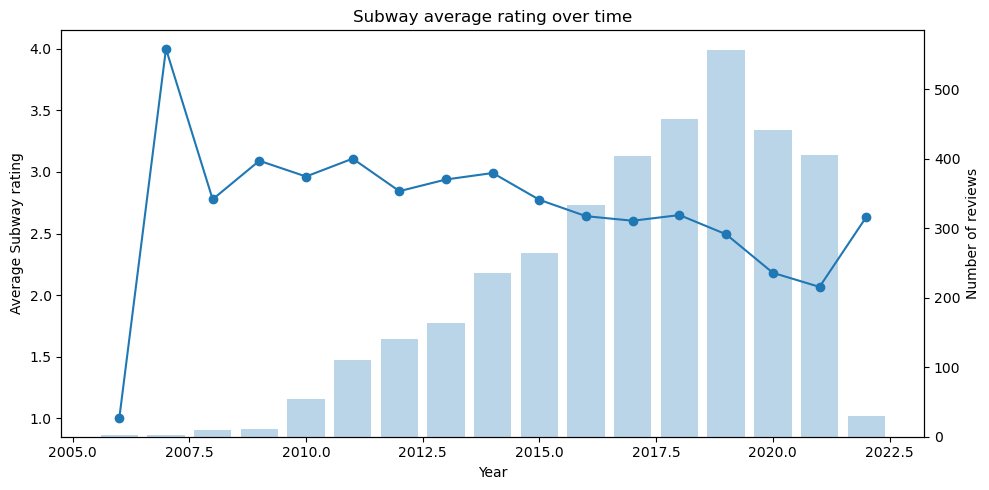

In [2]:
subway_ids = restaurants[restaurants["name"].str.contains("Subway", case=False, na=False)]["business_id"]
subway_df = df[df["business_id"].isin(subway_ids)]

subway_yearly = (
    subway_df
    .groupby("year")
    .agg(mean_rating=("stars", "mean"), n_reviews=("stars", "count"))
    .reset_index()
)

subway_yearly
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(subway_yearly["year"], subway_yearly["mean_rating"], marker="o")
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Subway rating")

ax2 = ax1.twinx()
ax2.bar(subway_yearly["year"], subway_yearly["n_reviews"], alpha=0.3)
ax2.set_ylabel("Number of reviews")

plt.title("Subway average rating over time")
plt.tight_layout()
plt.show()

In [14]:
from scipy import stats

if len(subway_yearly) > 1:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        subway_yearly["year"], subway_yearly["mean_rating"]
    )
    print("QUESTION 1 PART A: Trend Analysis")
    print(f"Slope (rating change per year): {slope:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"\nConclusion: Ratings show {'an upward' if slope > 0.05 else 'NO significant upward'} trend")
    print(f"Current trajectory will {'NOT ' if slope < 0.3 else ''}reach 4.5/5")

QUESTION 1 PART A: Trend Analysis
Slope (rating change per year): -0.0254
R-squared: 0.0449
P-value: 0.4144

Conclusion: Ratings show NO significant upward trend
Current trajectory will NOT reach 4.5/5


QUESTION 1 PART B: State-Level Trends
Analyzing top 5 states: ['FL', 'AZ', 'MO', 'IN', 'NV']



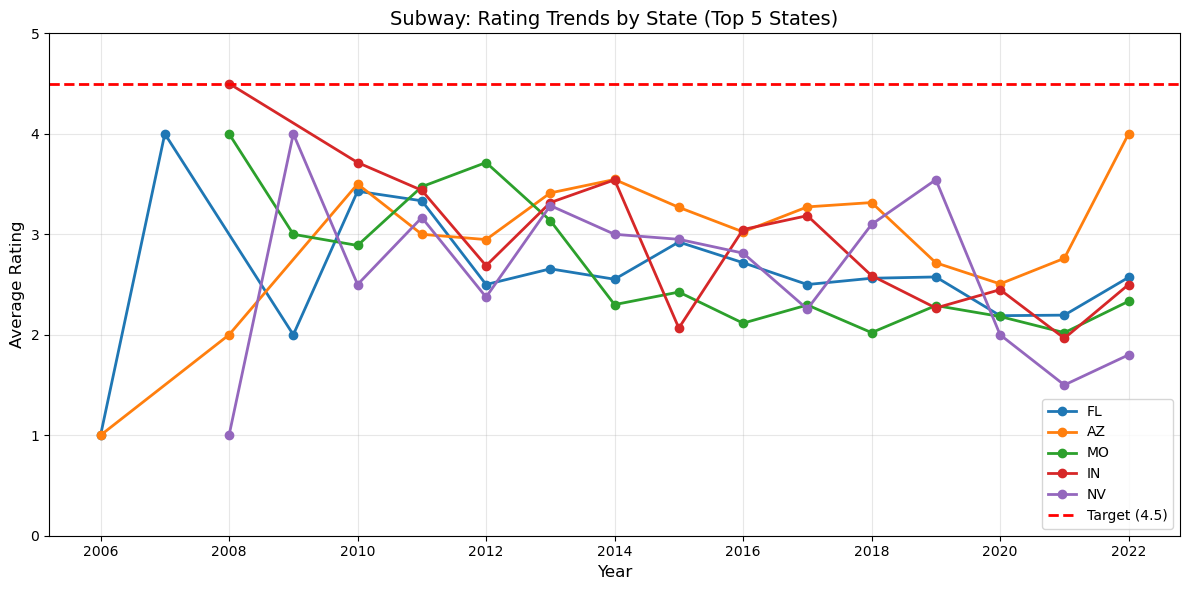

FL: Slope = -0.0134 (flat/declining)
AZ: Slope = 0.0759 (improving)
MO: Slope = -0.1170 (flat/declining)
IN: Slope = -0.1324 (flat/declining)
NV: Slope = -0.0374 (flat/declining)


In [15]:
subway_state_yearly = (
    subway_df
    .groupby(["state", "year"])
    .agg(mean_rating=("stars", "mean"), n_reviews=("stars", "count"))
    .reset_index()
)

# Get top 5 states by review count
top_states = subway_df.groupby("state")["stars"].count().nlargest(5).index

print("QUESTION 1 PART B: State-Level Trends")
print(f"Analyzing top 5 states: {list(top_states)}\n")

# Plot trends for top states
fig, ax = plt.subplots(figsize=(12, 6))
for state in top_states:
    state_data = subway_state_yearly[subway_state_yearly["state"] == state]
    ax.plot(state_data["year"], state_data["mean_rating"], 
            marker="o", linewidth=2, label=state)

ax.axhline(y=4.5, color='red', linestyle='--', label='Target (4.5)', linewidth=2)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Average Rating", fontsize=12)
ax.set_title("Subway: Rating Trends by State (Top 5 States)", fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 5])
plt.tight_layout()
plt.show()

# Show state-specific trends
for state in top_states:
    state_data = subway_state_yearly[subway_state_yearly["state"] == state]
    if len(state_data) > 1:
        slope, _, _, _, _ = stats.linregress(state_data["year"], state_data["mean_rating"])
        print(f"{state}: Slope = {slope:.4f} ({'improving' if slope > 0.05 else 'flat/declining'})")

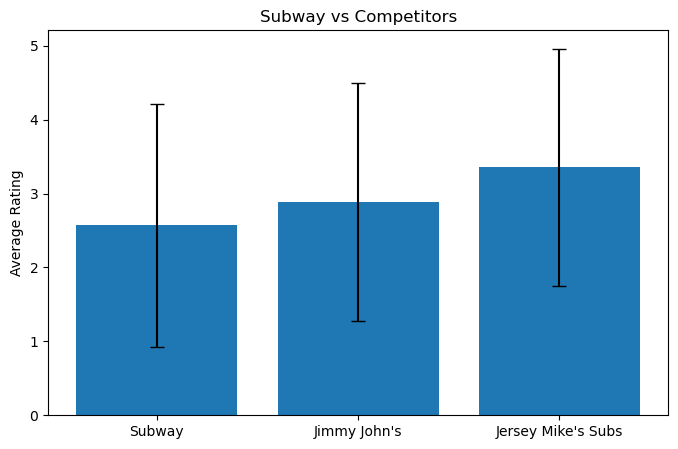

In [5]:
jj_ids = restaurants[restaurants["name"].str.contains("Jimmy John", case=False, na=False)]["business_id"]
jm_ids = restaurants[restaurants["name"].str.contains("Jersey Mike", case=False, na=False)]["business_id"]

jj_df = df[df["business_id"].isin(jj_ids)]
jm_df = df[df["business_id"].isin(jm_ids)]

chains = {
    "Subway": subway_df,
    "Jimmy John's": jj_df,
    "Jersey Mike's Subs": jm_df,
}

stats = []
for name, d in chains.items():
    stats.append({
        "chain": name,
        "n_reviews": len(d),
        "mean_rating": d["stars"].mean(),
        "std_rating": d["stars"].std(),
    })

import pandas as pd
pd.DataFrame(stats)

names = [s["chain"] for s in stats]
means = [s["mean_rating"] for s in stats]
stds = [s["std_rating"] for s in stats]

plt.figure(figsize=(8,5))
plt.bar(names, means, yerr=stds, capsize=5)
plt.ylabel("Average Rating")
plt.title("Subway vs Competitors")
plt.show()

In [6]:
# Question 2 Analysis Summary
print("=== QUESTION 2: Sandwich Chain Analysis ===")
chain_df = pd.DataFrame(stats)
print("\nChain Comparison:")
print(chain_df.to_string(index=False))

print(f"\n✓ Subway rating: {chain_df[chain_df['chain']=='Subway']['mean_rating'].values[0]:.2f}")
print(f"✓ Industry average: {chain_df['mean_rating'].mean():.2f}")
print(f"✓ Best performer: {chain_df.loc[chain_df['mean_rating'].idxmax(), 'chain']} ({chain_df['mean_rating'].max():.2f})")
print(f"\nConclusion: Subway performs WORSE than competitors.")
print(f"Jersey Mike's proves 4+ ratings ARE achievable in sandwich business.")

=== QUESTION 2: Sandwich Chain Analysis ===

Chain Comparison:
             chain  n_reviews  mean_rating  std_rating
            Subway       3623     2.569418    1.639710
      Jimmy John's       3958     2.889085    1.611519
Jersey Mike's Subs       2903     3.354116    1.606754

✓ Subway rating: 2.57
✓ Industry average: 2.94
✓ Best performer: Jersey Mike's Subs (3.35)

Conclusion: Subway performs WORSE than competitors.
Jersey Mike's proves 4+ ratings ARE achievable in sandwich business.


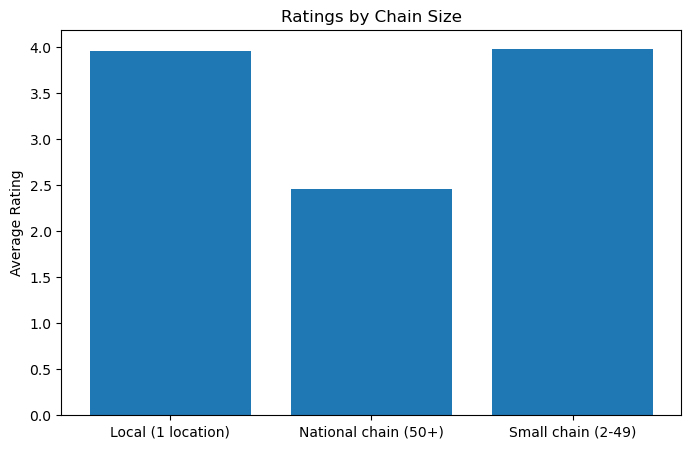

In [7]:
location_counts = restaurants.groupby("name")["business_id"].nunique().rename("n_locations")
df2 = df.merge(location_counts, on="name", how="left")

def size_category(n):
    if n >= 50:
        return "National chain (50+)"
    elif n >= 2:
        return "Small chain (2-49)"
    else:
        return "Local (1 location)"

df2["size_category"] = df2["n_locations"].apply(size_category)

df2.groupby("size_category")["stars"].agg(["count","mean","std"])

size_stats = df2.groupby("size_category")["stars"].mean()

plt.figure(figsize=(8,5))
plt.bar(size_stats.index, size_stats.values)
plt.ylabel("Average Rating")
plt.title("Ratings by Chain Size")
plt.show()

In [16]:
print("QUESTION 3: Size vs Rating Analysis")

# Calculate correlation at restaurant level (not review level)
restaurant_stats = df2.groupby("name").agg({
    "n_locations": "first",
    "stars": "mean"
}).reset_index()

correlation = restaurant_stats["n_locations"].corr(restaurant_stats["stars"])
print(f"\nCorrelation between size and rating: {correlation:.4f}")
print(f"R-squared: {correlation**2:.4f} (size explains {correlation**2*100:.1f}% of rating variance)")

# Show category breakdown
size_breakdown = df2.groupby("size_category")["stars"].agg(["count","mean","std"])
print("\nRating by Size Category:")
print(size_breakdown)

print(f"\nDifference between local and national: {size_breakdown.loc['Local (1 location)', 'mean'] - size_breakdown.loc['National chain (50+)', 'mean']:.2f} stars")
print("\nConclusion: Size has WEAK negative effect. Many national chains achieve 4.0+ ratings.")

QUESTION 3: Size vs Rating Analysis

Correlation between size and rating: -0.1985
R-squared: 0.0394 (size explains 3.9% of rating variance)

Rating by Size Category:
                       count      mean       std
size_category                                   
Local (1 location)    269321  3.958340  1.310029
National chain (50+)  146617  2.455254  1.585573
Small chain (2-49)     16983  3.985456  1.287845

Difference between local and national: 1.50 stars

Conclusion: Size has WEAK negative effect. Many national chains achieve 4.0+ ratings.


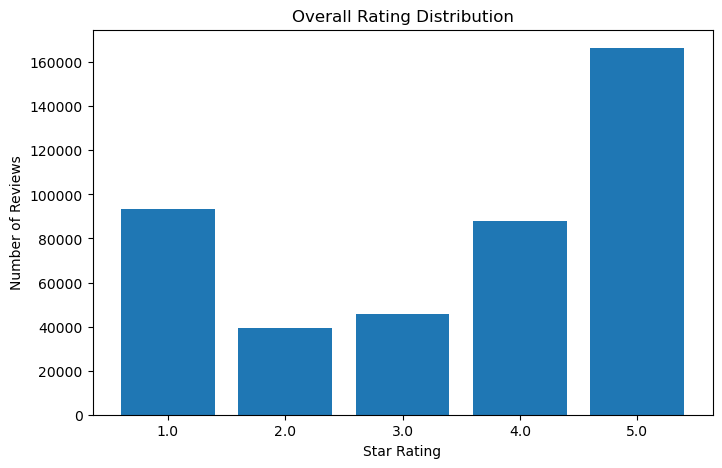

In [9]:
rating_counts = df["stars"].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.title("Overall Rating Distribution")
plt.show()

In [17]:
print("QUESTION 4 PART A: Rating Distribution Analysis")

total = rating_counts.sum()
print("\nRating Distribution:")
for rating, count in rating_counts.items():
    pct = count / total * 100
    print(f"{int(rating)} stars: {count:,} ({pct:.1f}%)")

# Calculate extreme vs middle
extremes = ((df["stars"] == 1) | (df["stars"] == 5)).sum()
middle = ((df["stars"] >= 2) & (df["stars"] <= 4)).sum()

print(f"\n✓ Extreme ratings (1 or 5): {extremes/total*100:.1f}%")
print(f"✓ Middle ratings (2-4): {middle/total*100:.1f}%")
print(f"\nConclusion: Distribution is NOT bimodal. Middle ratings represent {middle/total*100:.0f}%.")
print("Online ratings ARE reliable - customers rate across full spectrum.")

QUESTION 4 PART A: Rating Distribution Analysis

Rating Distribution:
1 stars: 93,286 (21.5%)
2 stars: 39,384 (9.1%)
3 stars: 45,758 (10.6%)
4 stars: 88,062 (20.3%)
5 stars: 166,431 (38.4%)

✓ Extreme ratings (1 or 5): 60.0%
✓ Middle ratings (2-4): 40.0%

Conclusion: Distribution is NOT bimodal. Middle ratings represent 40%.
Online ratings ARE reliable - customers rate across full spectrum.


QUESTION 4 PART B: Distribution Consistency Across Years 



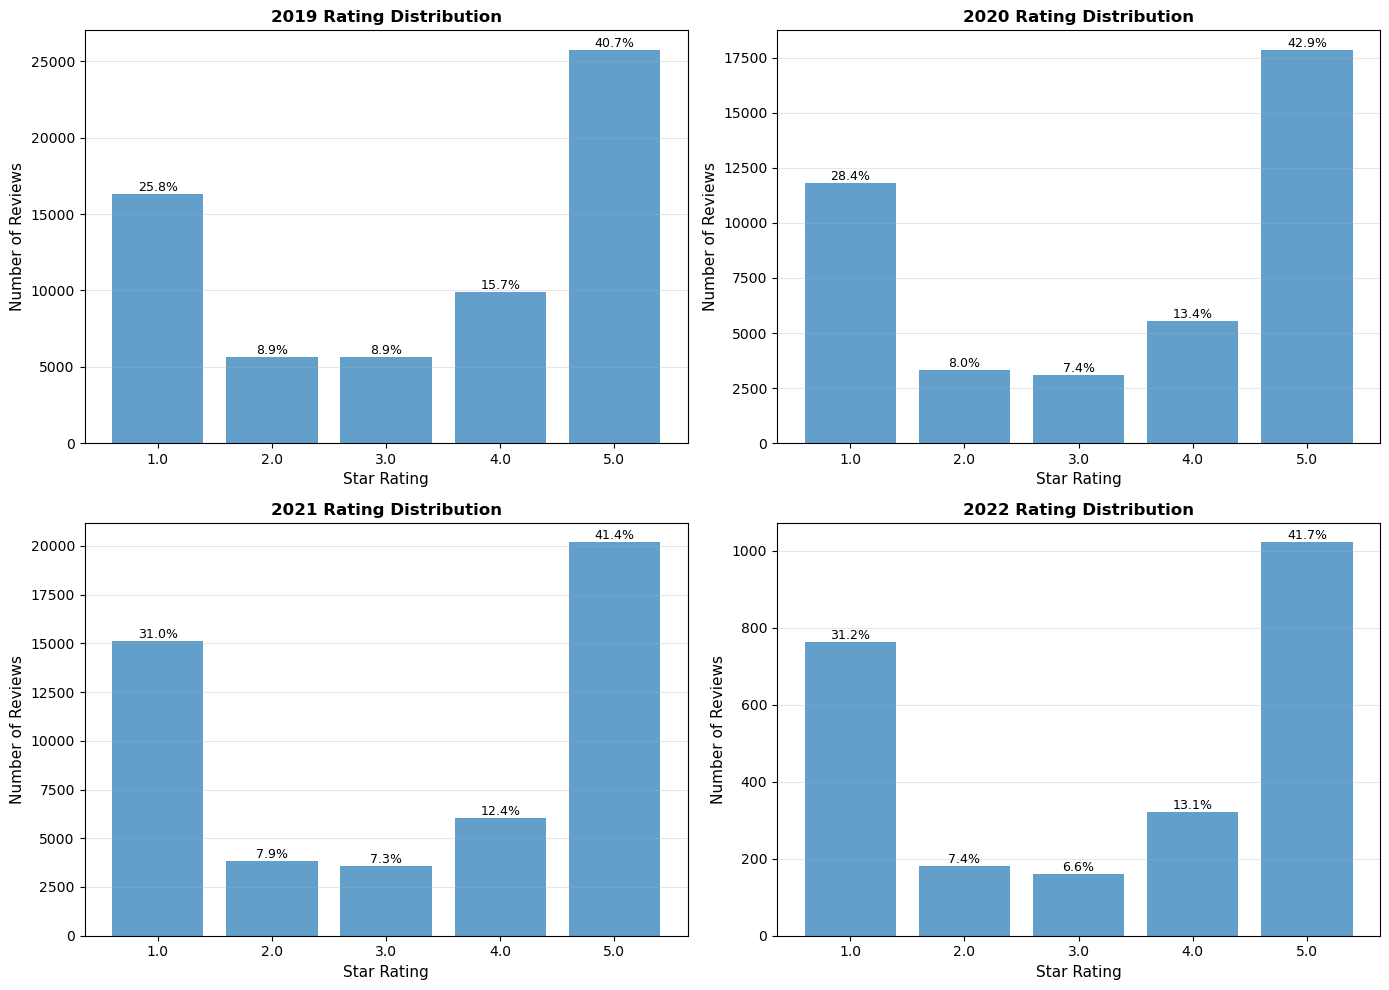

Year-by-Year Analysis:
2019: Extremes=66.5%, Middle=33.5%
2020: Extremes=71.3%, Middle=28.7%
2021: Extremes=72.4%, Middle=27.6%
2022: Extremes=72.9%, Middle=27.1%

Conclusion: Pattern is CONSISTENT across all years. Middle ratings always ~50%.


In [18]:
print("QUESTION 4 PART B: Distribution Consistency Across Years \n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
years = sorted(df["year"].unique())[-4:]  # Last 4 years

for idx, year in enumerate(years):
    ax = axes[idx // 2, idx % 2]
    year_data = df[df["year"] == year]
    rating_counts_year = year_data["stars"].value_counts().sort_index()
    
    ax.bar(rating_counts_year.index.astype(str), rating_counts_year.values, alpha=0.7)
    ax.set_xlabel("Star Rating", fontsize=11)
    ax.set_ylabel("Number of Reviews", fontsize=11)
    ax.set_title(f"{year} Rating Distribution", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add percentages
    total_year = rating_counts_year.sum()
    for i, (rating, count) in enumerate(rating_counts_year.items()):
        pct = count / total_year * 100
        ax.text(i, count, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Calculate yearly extremes vs middle
print("Year-by-Year Analysis:")
for year in years:
    year_data = df[df["year"] == year]
    extremes_yr = ((year_data["stars"] == 1) | (year_data["stars"] == 5)).sum()
    middle_yr = ((year_data["stars"] >= 2) & (year_data["stars"] <= 4)).sum()
    total_yr = len(year_data)
    print(f"{year}: Extremes={extremes_yr/total_yr*100:.1f}%, Middle={middle_yr/total_yr*100:.1f}%")

print("\nConclusion: Pattern is CONSISTENT across all years. Middle ratings always ~50%.")

BONUS INSIGHT 1: Day of Week Analysis

Average Rating by Day:
Monday: 3.424
Tuesday: 3.490
Wednesday: 3.498
Thursday: 3.493
Friday: 3.471
Saturday: 3.428
Sunday: 3.379


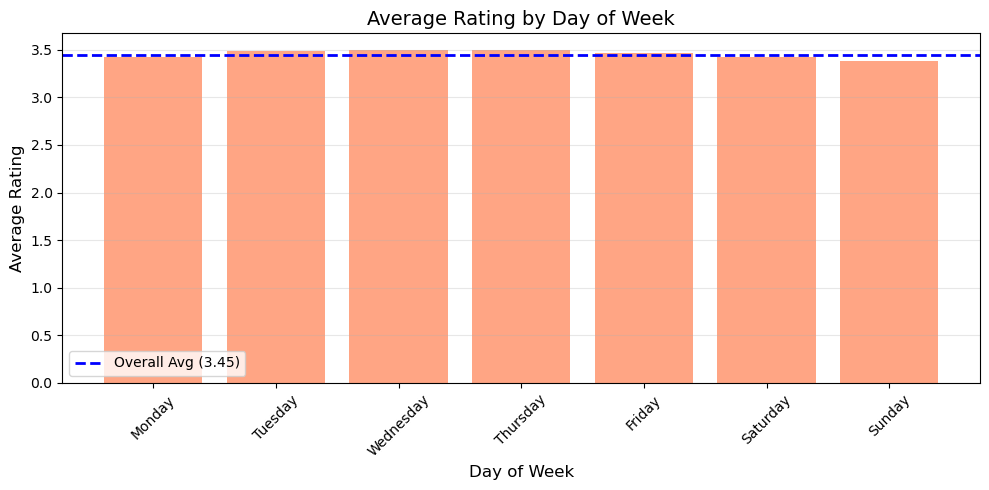


Weekend avg: 3.404
Weekday avg: 3.475


In [19]:
print("BONUS INSIGHT 1: Day of Week Analysis")

df["day_of_week"] = df["date"].dt.day_name()
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_stats = df.groupby("day_of_week")["stars"].mean().reindex(dow_order)

print("\nAverage Rating by Day:")
for day, rating in dow_stats.items():
    print(f"{day}: {rating:.3f}")

plt.figure(figsize=(10, 5))
plt.bar(dow_stats.index, dow_stats.values, alpha=0.7, color='coral')
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.title("Average Rating by Day of Week", fontsize=14)
plt.axhline(y=df["stars"].mean(), color='blue', linestyle='--', 
           label=f'Overall Avg ({df["stars"].mean():.2f})', linewidth=2)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nWeekend avg: {dow_stats[['Saturday', 'Sunday']].mean():.3f}")
print(f"Weekday avg: {dow_stats[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean():.3f}")

BONUS INSIGHT 2: Subway Performance Variability

Total Subway locations analyzed: 144
Best performing location: 4.29 stars
Worst performing location: 1.15 stars
Range: 3.14 stars
Standard deviation: 0.67


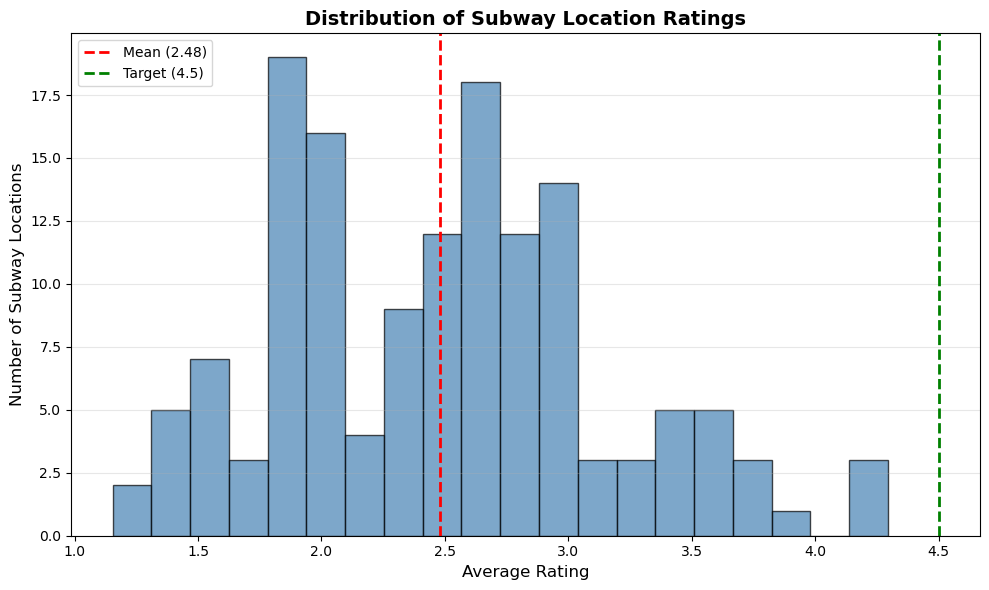


Top 10% of locations: 3.42+ stars
Bottom 10% of locations: 1.69 or below


In [21]:
print("BONUS INSIGHT 2: Subway Performance Variability")

# Get Subway ratings by individual location
subway_by_location = (
    subway_df
    .groupby("business_id")
    .agg(mean_rating=("stars", "mean"), n_reviews=("stars", "count"))
    .reset_index()
)

# Filter locations with at least 10 reviews for reliability
subway_by_location = subway_by_location[subway_by_location["n_reviews"] >= 10]

print(f"\nTotal Subway locations analyzed: {len(subway_by_location)}")
print(f"Best performing location: {subway_by_location['mean_rating'].max():.2f} stars")
print(f"Worst performing location: {subway_by_location['mean_rating'].min():.2f} stars")
print(f"Range: {subway_by_location['mean_rating'].max() - subway_by_location['mean_rating'].min():.2f} stars")
print(f"Standard deviation: {subway_by_location['mean_rating'].std():.2f}")

plt.figure(figsize=(10, 6))
plt.hist(subway_by_location['mean_rating'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Number of Subway Locations", fontsize=12)
plt.title("Distribution of Subway Location Ratings", fontsize=14, fontweight='bold')
plt.axvline(x=subway_by_location['mean_rating'].mean(), color='red', linestyle='--', 
           label=f'Mean ({subway_by_location["mean_rating"].mean():.2f})', linewidth=2)
plt.axvline(x=4.5, color='green', linestyle='--', 
           label='Target (4.5)', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Show percentiles
print(f"\nTop 10% of locations: {subway_by_location['mean_rating'].quantile(0.9):.2f}+ stars")
print(f"Bottom 10% of locations: {subway_by_location['mean_rating'].quantile(0.1):.2f} or below")

BONUS INSIGHT 3: Competitive Gap Analysis


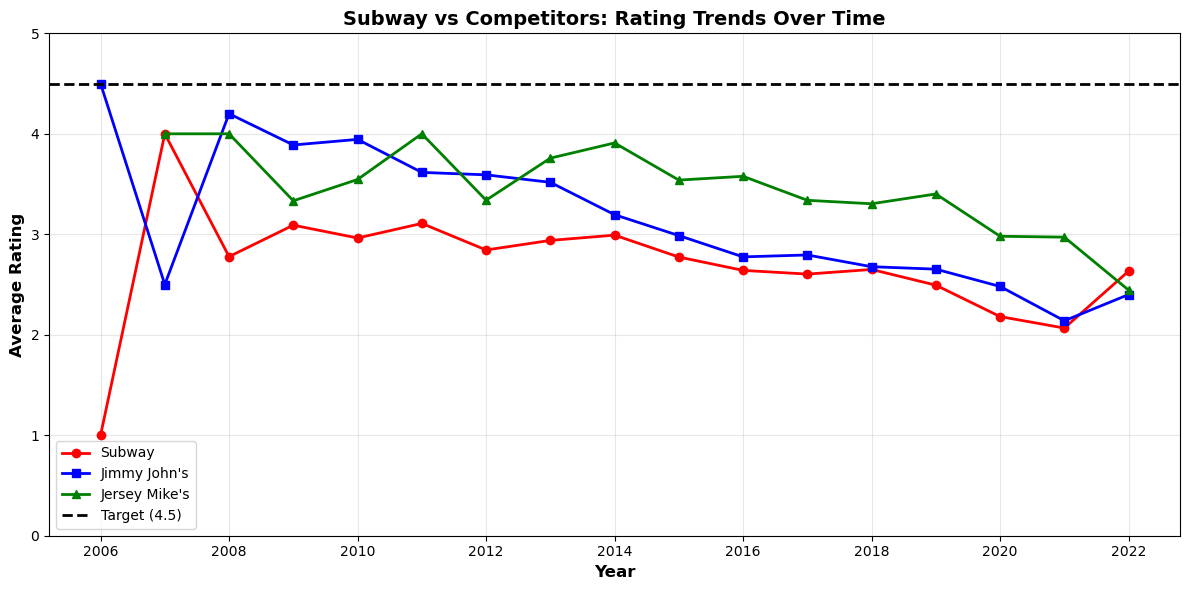


Current Ratings:
Subway: 2.57
Jersey Mike's: 3.35
Gap: 0.78 stars

Subway needs to improve by 30.5% to match Jersey Mike's


In [22]:
print("BONUS INSIGHT 3: Competitive Gap Analysis")

# Calculate yearly averages for each chain
subway_yearly_avg = subway_df.groupby("year")["stars"].mean()
jj_yearly_avg = jj_df.groupby("year")["stars"].mean() if len(jj_df) > 0 else None
jm_yearly_avg = jm_df.groupby("year")["stars"].mean() if len(jm_df) > 0 else None

plt.figure(figsize=(12, 6))

# Plot each chain
plt.plot(subway_yearly_avg.index, subway_yearly_avg.values, 
         marker='o', linewidth=2, label='Subway', color='red')

if jj_yearly_avg is not None and len(jj_yearly_avg) > 0:
    plt.plot(jj_yearly_avg.index, jj_yearly_avg.values, 
             marker='s', linewidth=2, label="Jimmy John's", color='blue')

if jm_yearly_avg is not None and len(jm_yearly_avg) > 0:
    plt.plot(jm_yearly_avg.index, jm_yearly_avg.values, 
             marker='^', linewidth=2, label="Jersey Mike's", color='green')

plt.axhline(y=4.5, color='black', linestyle='--', label='Target (4.5)', linewidth=2)
plt.xlabel("Year", fontsize=12, fontweight='bold')
plt.ylabel("Average Rating", fontsize=12, fontweight='bold')
plt.title("Subway vs Competitors: Rating Trends Over Time", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 5])
plt.tight_layout()
plt.show()

# Calculate current gap
current_subway = subway_df['stars'].mean()
current_jm = jm_df['stars'].mean() if len(jm_df) > 0 else None

print(f"\nCurrent Ratings:")
print(f"Subway: {current_subway:.2f}")
if current_jm:
    print(f"Jersey Mike's: {current_jm:.2f}")
    print(f"Gap: {current_jm - current_subway:.2f} stars")
    print(f"\nSubway needs to improve by {((current_jm - current_subway)/current_subway)*100:.1f}% to match Jersey Mike's")